In [148]:
import requests
import pandas as pd
from meteostat import Hourly, Point, Stations
stations = Stations()
from datetime import datetime
from values import rename_dict
pd.set_option('display.max_rows', 500)
import numpy as np
import pickle

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError, R2Score
from keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

## Güneş Enerji Santrallerinin verileri EPDK

In [149]:
gesler = pd.read_excel('ges_lisans.xls')

## Fonksiyonlar

In [150]:
def generate_requests(start_date, end_date, power_plant_id):
    requests_list = []

    # Tarih aralığındaki yılları bul
    start = datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.strptime(end_date, "%Y-%m-%d")
    years = range(start.year, end.year + 1)

    # Her yıl için istek oluştur
    for year in years:
        # İstek için başlangıç ve bitiş tarihlerini ayarla
        req_start = max(start, datetime(year, 1, 1))
        req_end = min(end, datetime(year, 12, 31))
        if req_end < req_start:
            continue

        data = {
            "endDate": "{}T00:00:00+03:00".format(req_end.strftime("%Y-%m-%d")),
            "startDate": "{}T00:00:00+03:00".format(req_start.strftime("%Y-%m-%d")),
            "powerPlantId": power_plant_id,
            "page": {
                    "sort": {
                        "field": "date",
                        "direction": "ASC"
                    }
            }
        }
        headers = {
            "Content-Type": "application/json",
            "Accept": "application/json"
        }
        # İstek gönder
        try:
            gen_req = requests.post("https://seffaflik.epias.com.tr/electricity-service/v1/generation/data/realtime-generation", json=data, headers=headers).json()['items']
        except:
            return {}
        requests_list.append(gen_req)
    return requests_list

def get_meteorlogic_data(start_date, end_date, enlem, boylam):
    station = stations.nearby(enlem, boylam).fetch(1)
    station_distance = station['distance'][0]
    station_id = station.index[0]
    if station_distance > 45000:
        return pd.DataFrame
    data = Hourly(station_id, start_date, end_date, timezone='Turkey')
    data = data.fetch()
    data.reset_index(inplace=True)
    return data

def weather_data(df, ges):
    start_date_string = pd.to_datetime(df['date']).min()
    start = datetime.strptime(start_date_string.strftime('%Y-%m-%d'), '%Y-%m-%d')
    end_date_string = pd.to_datetime(df['date']).max()
    end = datetime.strptime(end_date_string.strftime('%Y-%m-%d'), '%Y-%m-%d')
    enlem = gesler[gesler['Tesis Adı'] == ges].Enlem.values[0]
    boylam = gesler[gesler['Tesis Adı'] == ges].Boylam.values[0]
    hava = get_meteorlogic_data(start_date=start, end_date=end, enlem=enlem, boylam=boylam)
    if hava.empty:
        print(f"{ges} hava verisi çekilemedi il: {gesler[gesler['Tesis Adı']==ges]['İl']}")
        return pd.DataFrame()
    hava.rename(columns={'time':'date'},inplace=True)
    df = pd.merge(df, hava, on='date', how='inner')
    return df

def add_new_cols(df):
    df["year"] = df["date"].dt.year
    df["yearday"] = df["date"].dt.dayofyear
    df["hour"] = df["date"].dt.hour
    df["week"] = df["date"].dt.isocalendar().week
    df["coco"] = df["coco"].astype(float).fillna(-100.)
    df["solar_irradiance"] = (1+0.033*np.cos(2*np.pi*df["yearday"]/365))
    df.drop(labels=["yearday", "tsun"], axis=1, inplace=True)
    df["rhum_r3mean"] = df["rhum"].rolling(3).mean()
    df["temp_r3mean"] = df["temp"].rolling(3).mean()
    df = fourier_ext(df, "hour", 23, [1])
    df = fourier_ext(df, "wdir", 360, [1])
    df["wspd_sin"] = df["wspd"] * df["wdir_sin1"]
    df["wspd_cos"] = df["wspd"] * df["wdir_cos1"]
    df.drop(labels=["wspd", "wdir"], axis=1, inplace=True)
    return df

def fourier_ext(df, col, period, orders):
    for order in orders:
        df[col+'_sin'+str(order)] = np.sin(order * 2 * np.pi * df[col]/period)
        df[col+'_cos'+str(order)] = np.cos(order * 2 * np.pi * df[col]/period)
    return df

def sun_data(df, ges):
    import astropy.coordinates as coord
    import astropy.units as u
    from astropy.time import Time
    from astral import LocationInfo
    from astral.location import Location
    import pysolar

    def get_solar_radiation(date, lat, lon):
        altitude_deg = pysolar.solar.get_altitude(lat,lon,date)
        if altitude_deg <= 0:
            return 0
        else:
            return pysolar.radiation.get_radiation_direct(date,altitude_deg)
    
    enlem = gesler[gesler['Tesis Adı'] == ges].Enlem.values[0]
    boylam = gesler[gesler['Tesis Adı'] == ges].Boylam.values[0]
    sehir = gesler[gesler['Tesis Adı'] == ges]['İl'].values[0]

    target_loc = LocationInfo(sehir, 'Turkey', "Europe/Istanbul", enlem, boylam)

    df['sun_azimuth_angle'] = df['date'].apply(Location(target_loc).solar_azimuth)
    df['sun_elv_angle'] = df['date'].apply(Location(target_loc).solar_elevation)
    #df['solar_radiation'] = df['date'].apply(lambda x: get_solar_radiation(x, enlem, boylam))

    # Convert 'date' column to Astropy Time objects with Turkey timezone
    times = Time(pd.to_datetime(df['date'], utc=True).dt.tz_convert('Europe/Istanbul'))

    loc = coord.EarthLocation(lon=enlem * u.deg, lat=boylam * u.deg)
    altaz = coord.AltAz(location=loc, obstime=times)
    sun = coord.get_sun(times)
    df['sun_distance'] = sun.transform_to(altaz).distance.AU
    return df

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    # Calculate absolute errors
    absolute_errors = np.abs(y_true - y_pred)
    # Calculate absolute percentage errors
    absolute_percentage_errors = np.abs((y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))
    # Avoid division by zero
    absolute_percentage_errors[np.isnan(absolute_percentage_errors)] = 0
    # Calculate SMAPE
    smape = np.mean(absolute_percentage_errors)
    return smape




## Verileri EPİAŞ'tan topla

### Tüm Lisanslı Santraller

In [4]:
all_ges_outputs=[]
for power_plant_id in list(gesler['id']):
    requests_list = generate_requests("2017-01-01", "2024-04-01", power_plant_id)
    ges = pd.DataFrame(columns=['date', 'hour', 'total'])
    for req in requests_list:
        ges = pd.concat([ges, pd.DataFrame(req)]).reset_index(drop=True)
    ges.rename(columns={"total":f"{power_plant_id}"}, inplace=True)
    ges = ges[['date', 'hour', f'{power_plant_id}']]
    ges['date'] = pd.to_datetime(ges['date'])
    if not ges.empty:
        all_ges_outputs.append(ges)

for df in all_ges_outputs:
    df.set_index('date', inplace=True)
    df.index = df.index.tz_convert('Turkey')
    df.reset_index(inplace=True)
    df.rename(columns=rename_dict, inplace=True)

with open("all_ges_outputs", 'wb') as file:
    pickle.dump(all_ges_outputs, file)

### SOLENTEGRE GES

In [151]:
power_plant_id = 2108
requests_list = generate_requests("2017-01-01", "2024-02-16", power_plant_id)
ges = pd.DataFrame(columns=['date', 'hour', 'total'])
for req in requests_list:
    ges = pd.concat([ges, pd.DataFrame(req)]).reset_index(drop=True)
ges.rename(columns={"total":f"{power_plant_id}"}, inplace=True)
ges = ges[['date', 'hour', f'{power_plant_id}']]
ges['date'] = pd.to_datetime(ges['date'])

## Verilere hava durumu verilerini ekle, verisi olmayanları sil

### Tüm Lisanslı Santraller

In [ ]:
havali_gesler = []
for i,df in enumerate(all_ges_outputs):
    ges = all_ges_outputs[i].columns[2]
    havali_gesler.append(weather_data(df, ges))

### SOLENTEGRE GES

In [152]:
df = weather_data(ges, 'SOLENTEGRE GES')

## Güneş ile alakalı verileri oluştur

In [9]:
final_dfs = []
for i, df in enumerate(havali_gesler):
    ges = havali_gesler[i].columns[2]
    final_dfs.append(sun_data(df, ges))


In [153]:
df = sun_data(df, "SOLENTEGRE GES")

## Değişken oluşturma, tekrarlayan değişkenleri normalize etme

In [12]:
for df in final_dfs:
    df = add_new_cols(df)


In [154]:
df = add_new_cols(df)

## Lag ekleme

In [ ]:
for df in final_dfs:
    for i in list(range(1,8)):
        for col in ["rhum", "temp", "coco"]:
            df[col+str(i)] = df[col].shift(-i)

In [14]:
for df in final_dfs:
    df.columns.values[2] = 'output'

In [15]:
pd.set_option('display.max_columns', None)

In [16]:
total_rows = 0
for i in range(len(final_dfs)):
    total_rows += final_dfs[i].shape[0]
print(f"{total_rows}, {final_dfs[0].shape[1]}")

608344, 25


with open('final_dfs.pkl', 'wb') as f:
    pickle.dump(final_dfs, f)

In [86]:
with open('final_dfs.pkl', 'rb') as f:
    loaded_dfs = pickle.load(f)

In [18]:
#narx lstm
#naive, trend equation(x as time y bağımlı)

In [21]:
combined_df = pd.concat(loaded_dfs, ignore_index=True)

In [22]:
combined_df.drop(columns='date', inplace=True)

In [23]:
pd.set_option('display.max_columns', None)
combined_df

,hour,output,temp,dwpt,rhum,prcp,snow,wpgt,pres,tsun,coco,sun_azimuth_angle,sun_elv_angle,sun_distance,year,week,solar_irradiance,tsun_r3mean,rhum_r3mean,temp_r3mean,hour_sin1,hour_cos1,wdir_sin1,wdir_cos1,wspd_sin,wspd_cos,tsun1,rhum1,temp1,coco1,tsun2,rhum2,temp2,coco2,tsun3,rhum3,temp3,coco3,tsun4,rhum4,temp4,coco4,tsun5,rhum5,temp5,coco5,tsun6,rhum6,temp6,coco6,tsun7,rhum7,temp7,coco7
0,17,NaN,13.6,6.7,63.0,NaN,NaN,NaN,1018.7,NaN,-100.0,232.262154,8.551229,0.983255,2021,53,1.032995,NaN,NaN,NaN,-9.976688e-01,-0.068242,-0.121869,0.992546,-0.487477,3.970185,NaN,75.0,11.7,-100.0,NaN,76.0,11.5,-100.0,NaN,77.0,10.9,-100.0,NaN,76.0,10.3,-100.0,NaN,81.0,8.5,-100.0,NaN,81.0,7.9,-100.0,NaN,82.0,7.2,-100.0
1,18,NaN,11.7,7.4,75.0,0.0,NaN,NaN,1019.9,NaN,-100.0,241.841338,-1.299618,0.983263,2021,53,1.032995,NaN,NaN,NaN,-9.790841e-01,0.203456,-0.406737,0.913545,-1.464252,3.288764,NaN,76.0,11.5,-100.0,NaN,77.0,10.9,-100.0,NaN,76.0,10.3,-100.0,NaN,81.0,8.5,-100.0,NaN,81.0,7.9,-100.0,NaN,82.0,7.2,-100.0,NaN,84.0,6.5,-100.0
2,19,NaN,11.5,7.4,76.0,0.0,NaN,NaN,1020.2,NaN,-100.0,250.441782,-12.347460,0.983272,2021,53,1.032995,NaN,71.333333,12.266667,-8.878852e-01,0.460065,0.965926,-0.258819,1.738666,-0.465874,NaN,77.0,10.9,-100.0,NaN,76.0,10.3,-100.0,NaN,81.0,8.5,-100.0,NaN,81.0,7.9,-100.0,NaN,82.0,7.2,-100.0,NaN,84.0,6.5,-100.0,NaN,86.0,5.9,-100.0
3,20,NaN,10.9,7.0,77.0,0.0,NaN,NaN,1020.5,NaN,-100.0,258.590663,-23.797415,0.983280,2021,53,1.032995,NaN,76.000000,11.366667,-7.308360e-01,0.682553,-0.017452,-0.999848,-0.038395,-2.199665,NaN,76.0,10.3,-100.0,NaN,81.0,8.5,-100.0,NaN,81.0,7.9,-100.0,NaN,82.0,7.2,-100.0,NaN,84.0,6.5,-100.0,NaN,86.0,5.9,-100.0,NaN,86.0,5.5,-100.0
4,21,NaN,10.3,6.3,76.0,0.0,NaN,NaN,1020.9,NaN,-100.0,266.922303,-35.572870,0.983288,2021,53,1.032995,NaN,76.333333,10.900000,-5.195840e-01,0.854419,-0.139173,-0.990268,-0.250512,-1.782483,NaN,81.0,8.5,-100.0,NaN,81.0,7.9,-100.0,NaN,82.0,7.2,-100.0,NaN,84.0,6.5,-100.0,NaN,86.0,5.9,-100.0,NaN,86.0,5.5,-100.0,NaN,87.0,5.1,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426507,20,NaN,11.0,5.9,71.0,0.0,NaN,NaN,1022.0,NaN,1.0,288.504274,-14.826469,0.999171,2024,13,1.000142,NaN,56.333333,14.333333,-7.308360e-01,0.682553,-0.766044,-0.642788,-8.426489,-7.070664,NaN,67.0,11.0,1.0,NaN,81.0,8.0,1.0,NaN,81.0,7.0,1.0,NaN,81.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426508,21,NaN,11.0,5.1,67.0,0.0,NaN,NaN,1022.0,NaN,1.0,299.694163,-25.506419,0.999191,2024,13,1.000142,NaN,65.333333,11.666667,-5.195840e-01,0.854419,-0.984808,-0.173648,-8.863270,-1.562834,NaN,81.0,8.0,1.0,NaN,81.0,7.0,1.0,NaN,81.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426509,22,NaN,8.0,4.9,81.0,0.0,NaN,NaN,1022.0,NaN,1.0,313.183468,-34.922318,0.999209,2024,13,1.000142,NaN,73.000000,10.000000,-2.697968e-01,0.962917,-0.866025,-0.500000,-11.258330,-6.500000,NaN,81.0,7.0,1.0,NaN,81.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426510,23,NaN,7.0,4.0,81.0,0.0,NaN,NaN,1022.0,NaN,1.0,329.945162,-42.209526,0.999225,2024,13,1.000142,NaN,76.333333,8.666667,-2.449294e-16,1.000000,-0.984808,-0.173648,-6.893654,-1.215537,NaN,81.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
combined_df.isna().sum()

hour                      0
output               426512
temp                   4346
dwpt                   4357
rhum                   4357
prcp                 176661
snow                 422919
wpgt                 370386
pres                  10825
tsun                 426512
coco                      0
sun_azimuth_angle         0
sun_elv_angle             0
sun_distance              0
year                      0
week                      0
solar_irradiance          0
tsun_r3mean          426512
rhum_r3mean            5262
temp_r3mean            5234
hour_sin1                 0
hour_cos1                 0
wdir_sin1              8892
wdir_cos1              8892
wspd_sin               8892
wspd_cos               8892
tsun1                426512
rhum1                  4368
temp1                  4357
coco1                    11
tsun2                426512
rhum2                  4379
temp2                  4368
coco2                    22
tsun3                426512
rhum3               

## Outlier Analysis

date outliers: 0
hour outliers: 0
2108 outliers: 5
temp outliers: 2
dwpt outliers: 247
rhum outliers: 0
prcp outliers: 478
snow outliers: 0
wpgt outliers: 0
pres outliers: 53
coco outliers: 0
sun_azimuth_angle outliers: 0
sun_elv_angle outliers: 0
sun_distance outliers: 0
year outliers: 0
week outliers: 0
solar_irradiance outliers: 0
rhum_r3mean outliers: 0
temp_r3mean outliers: 2
hour_sin1 outliers: 0
hour_cos1 outliers: 0
wdir_sin1 outliers: 0
wdir_cos1 outliers: 0
wspd_sin outliers: 376
wspd_cos outliers: 697


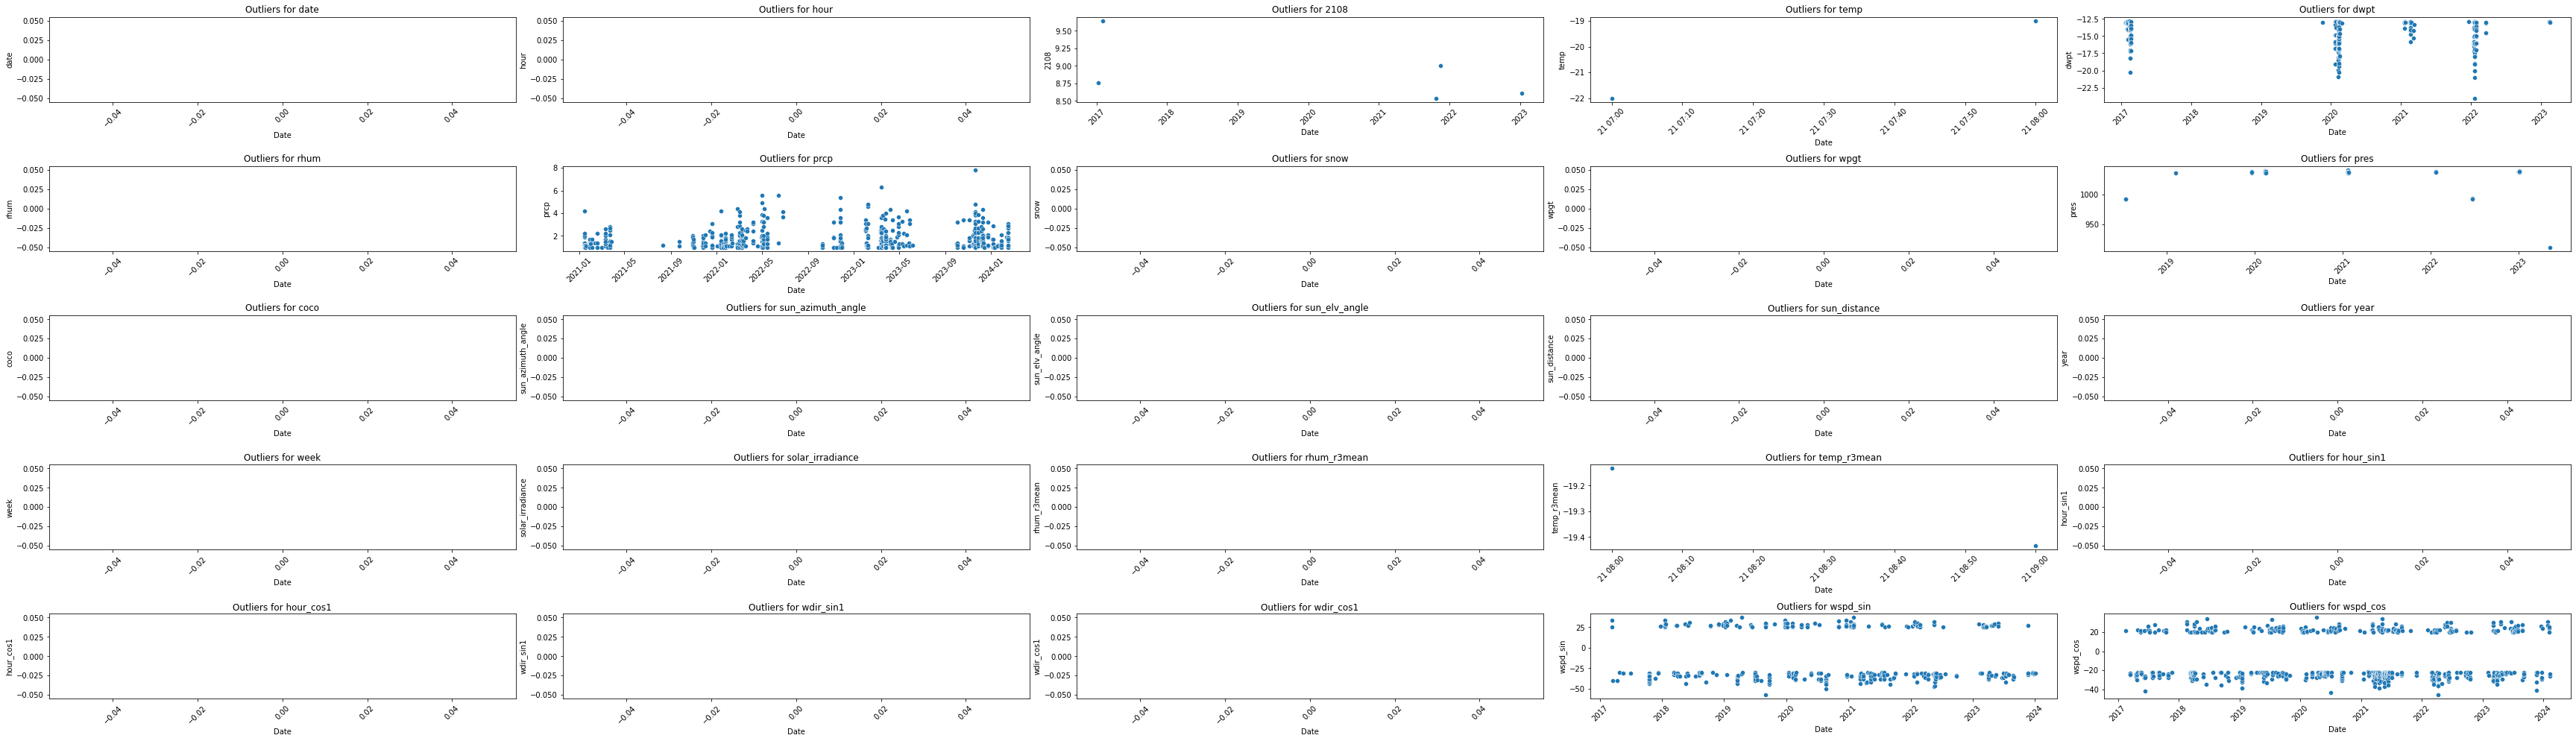

In [155]:
import seaborn as sns
import math

z_scores = (df - df.mean()) / df.std()

z_threshold = 3
outliers_z = (z_scores > z_threshold) | (z_scores < -z_threshold)

for col in df.columns:
    print(f"{col} outliers: {df[outliers_z[col]].shape[0]}")

num_rows = 6
num_cols = math.ceil(len(df.columns) / num_rows)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(48, 16))

if num_rows == 1:
    axes = axes.reshape(1, -1)
else:
    axes = axes.flatten()

for i, col in enumerate(df.columns):
    outliers_data = df[outliers_z[col]]
    
    sns.scatterplot(x='date', y=col, data=outliers_data, ax=axes[i])
    axes[i].set_title(f'Outliers for {col}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

We should remove empty values and fill them with ffill and bfill.

In [157]:
df[outliers_z] = np.nan
df = df.fillna(method='ffill').fillna(method='bfill')

# Model

In [159]:
df.to_csv("solentegre.csv")

In [ ]:
# Pull all santrals from pickle
with open('final_dfs.pkl', 'rb') as f:
    final_dfs = pickle.load(f)

In [160]:
def get_data_ready(df):
    df = df.ffill().bfill().fillna(0)
    df['date']= pd.to_datetime(df['date']).dt.tz_localize(None)
    df.index = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M:%S')
    df = df.drop(columns=['date', 'hour']).astype(float)
    return df

def df_to_X_y(df, window_size=6):
  df_as_np = df.to_numpy()
  X,y = [], []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

def get_other_ges(index):
    df = final_dfs[index]
    df = get_data_ready(df.drop('mech_capacity', axis=1))
    return (df, df_to_X_y(df, window_size=11))



In [ ]:
dfs = []
for df in final_dfs:
    dfs.append(get_data_ready(df))
all_df = pd.concat(dfs).sort_index()

In [161]:
df = get_data_ready(df)
df.columns.values[0] = 'output'

In [165]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
output,60467.0,1.548233,2.264423,0.000000,0.000000,0.000000,2.960000,8.330000
temp,60467.0,14.357473,11.052384,-18.000000,5.700000,13.000000,23.000000,42.000000
dwpt,60467.0,3.399767,5.320400,-12.700000,0.000000,3.800000,7.200000,18.400000
rhum,60467.0,56.354491,26.993341,5.000000,33.000000,54.000000,81.000000,100.000000
prcp,60467.0,0.014732,0.088572,0.000000,0.000000,0.000000,0.000000,0.900000
snow,60467.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
wpgt,60467.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pres,60467.0,1014.647702,7.210144,993.000000,1009.900000,1014.700000,1020.000000,1036.200000
coco,60467.0,-68.605438,47.945907,-100.000000,-100.000000,-100.000000,1.000000,26.000000
sun_azimuth_angle,60467.0,180.235116,100.269591,8.142717,89.825833,176.211004,269.441848,355.914535


In [166]:
X,y = df_to_X_y(df, window_size=24)
print(X.shape, y.shape)

In [168]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [177]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=256))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()
checkpoint = [ModelCheckpoint('model.keras', save_best_only=True, verbose=1),
              EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, mode='min', verbose=1)]

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 24, 64)         │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 24, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,841 (1.97 MB)

 Trainable params: 515,841 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [181]:
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=checkpoint, batch_size=None)

Epoch 1/100
1511/1512 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4214 - root_mean_squared_error: 0.6490
Epoch 1: val_loss did not improve from 0.38860
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 64s 38ms/step - loss: 0.4214 - root_mean_squared_error: 0.6490 - val_loss: 0.4174 - val_root_mean_squared_error: 0.6461
Epoch 2/100
1511/1512 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4360 - root_mean_squared_error: 0.6599
Epoch 2: val_loss did not improve from 0.38860
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step - loss: 0.4360 - root_mean_squared_error: 0.6599 - val_loss: 0.6828 - val_root_mean_squared_error: 0.8263
Epoch 3/100
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4165 - root_mean_squared_error: 0.6453
Epoch 3: val_loss did not improve from 0.38860
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 56s 37ms/step - loss: 0.4165 - root_mean_squared_error: 0.6453 - val_loss: 0.4090 - val_root_mean_squared_error: 0.6396
Epoch 4/100
1511/1512 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4133 - root_mean_squared_

In [198]:
model_again = Sequential()
model_again.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model_again.add(LSTM(units=64, return_sequences=True))
model_again.add(Dropout(0.2))
model_again.add(LSTM(units=128, return_sequences=True))
model_again.add(Dropout(0.2))
model_again.add(LSTM(units=256))
model_again.add(Dropout(0.2))
model_again.add(Dense(units=1))

model_again.summary()
checkpoint = [ModelCheckpoint('model.keras', save_best_only=True, verbose=1),
              EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, mode='min', verbose=1)]

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 24, 64)         │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 24, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 515,841 (1.97 MB)

 Trainable params: 515,841 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

In [199]:
model_again.load_weights('model.keras')

In [200]:
model_again.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [201]:
history_again = model_again.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=checkpoint, batch_size=None)

Epoch 1/100
1510/1512 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4093 - root_mean_squared_error: 0.6397
Epoch 1: val_loss improved from inf to 0.38502, saving model to model.keras
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - loss: 0.4093 - root_mean_squared_error: 0.6397 - val_loss: 0.3850 - val_root_mean_squared_error: 0.6206
Epoch 2/100
1510/1512 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3885 - root_mean_squared_error: 0.6232
Epoch 2: val_loss did not improve from 0.38502
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 55s 36ms/step - loss: 0.3885 - root_mean_squared_error: 0.6232 - val_loss: 0.3939 - val_root_mean_squared_error: 0.6276
Epoch 3/100
1510/1512 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4076 - root_mean_squared_error: 0.6384
Epoch 3: val_loss improved from 0.38502 to 0.37699, saving model to model.keras
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - loss: 0.4076 - root_mean_squared_error: 0.6384 - val_loss: 0.3770 - val_root_mean_squared_error: 0.6141
Epoch 4/100
1512/1512 ━━━━━━━

In [204]:
model.evaluate(X_test, y_test, verbose=1)

 21/189 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3120 - root_mean_squared_error: 0.5548

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.3106 - root_mean_squared_error: 0.5558


[0.3744625449180603, 0.6120187044143677]

In [206]:
model_again.evaluate(X_test, y_test, verbose=1)

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.3215 - root_mean_squared_error: 0.5662


[0.34151196479797363, 0.5844964385032654]

In [205]:
loaded_model = keras.saving.load_model("best_model.keras")
loaded_model.evaluate(X_test, y_test)

  1/189 ━━━━━━━━━━━━━━━━━━━━ 55s 297ms/step - loss: 0.6245 - root_mean_squared_error: 0.7902

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2801 - root_mean_squared_error: 0.5277


[0.3171464502811432, 0.5632452964782715]

Model trained before is better so we use best_model for further analysis.

In [34]:
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
print("Symmetric Mean Absolute Percentage Error:", smape)

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Mean Squared Error: 0.3171251718488675
Root Mean Squared Error: 0.5631386790559387
R2 Score: 0.9282186663504338
Mean Absolute Error: 0.2794175973895959


In [131]:
from sklearn.metrics import mean_squared_error
y_pred = loaded_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
print("Symmetric Mean Absolute Percentage Error:", smape)

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Mean Squared Error: 0.33868888650517737
Root Mean Squared Error: 0.5819698329855056
R2 Score: 0.9233377160699991
Mean Absolute Error: 0.2814817390153485
Symmetric Mean Absolute Percentage Error: 1.7433303715384674


This is not the best model, it's another model I tried.

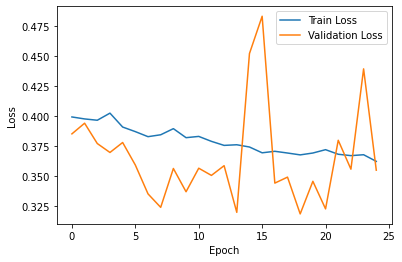

In [305]:
import matplotlib.pyplot as plt

plt.plot(history_again.history['loss'], label='Train Loss')
plt.plot(history_again.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [209]:
def plot_predictions(model, np_x_y_arrays, start=0, end=100):
    predictions = model.predict(np_x_y_arrays[0]).flatten()
    predictions[predictions < 0.03 ] = 0
    pred_df = pd.DataFrame(data={'Predictions': predictions, 'Actuals': np_x_y_arrays[1]})
    
    plt.figure(figsize=(18, 12))
    plt.plot(pred_df['Predictions'][start:end], color='red', label='Predictions')
    plt.plot(pred_df['Actuals'][start:end], color='green', label='Actuals')
    plt.legend()
    
    return mean_squared_error(predictions, np_x_y_arrays[1])

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


0.31715805189338775

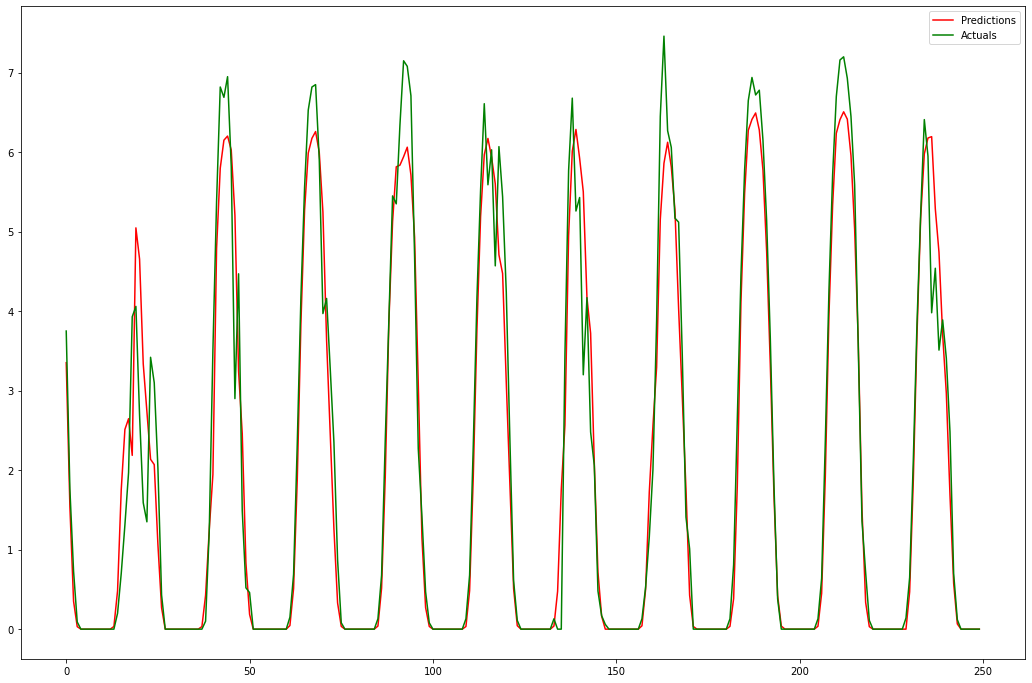

In [303]:
plot_predictions(loaded_model, (X_test, y_test), start=0, end=250)

In [216]:
gesler = pd.read_excel('ges_lisans.xls')
power_plant_id = 2108
requests_list = generate_requests("2024-02-16", "2024-04-16", power_plant_id)
ges_last_2_months = pd.DataFrame(columns=['date', 'hour', 'total'])
for req in requests_list:
    ges_last_2_months = pd.concat([ges_last_2_months, pd.DataFrame(req)]).reset_index(drop=True)
ges_last_2_months.rename(columns={"total":f"{power_plant_id}"}, inplace=True)
ges_last_2_months = ges_last_2_months[['date', 'hour', f'{power_plant_id}']]
ges_last_2_months['date'] = pd.to_datetime(ges_last_2_months['date'])
last_2_months_df = weather_data(ges_last_2_months, 'SOLENTEGRE GES')
last_2_months_df = sun_data(last_2_months_df, "SOLENTEGRE GES")
last_2_months_df = add_new_cols(last_2_months_df)
last_2_months_df = get_data_ready(last_2_months_df)

In [219]:
X_last, y_last = df_to_X_y(last_2_months_df, window_size=24)

In [302]:
from sklearn.metrics import mean_squared_error
test_predictions = model.predict(X_last).flatten()
test_predictions[test_predictions < 0.05] = 0
test_results = pd.DataFrame(data={'Val Predictions':test_predictions, 'Actuals':y_last})
print(mean_squared_error(test_predictions, y_last))
test_results

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
0.6075235077755634


,Val Predictions,Actuals
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
1412,0.0,0.0
1413,0.0,0.0
1414,0.0,0.0
1415,0.0,0.0


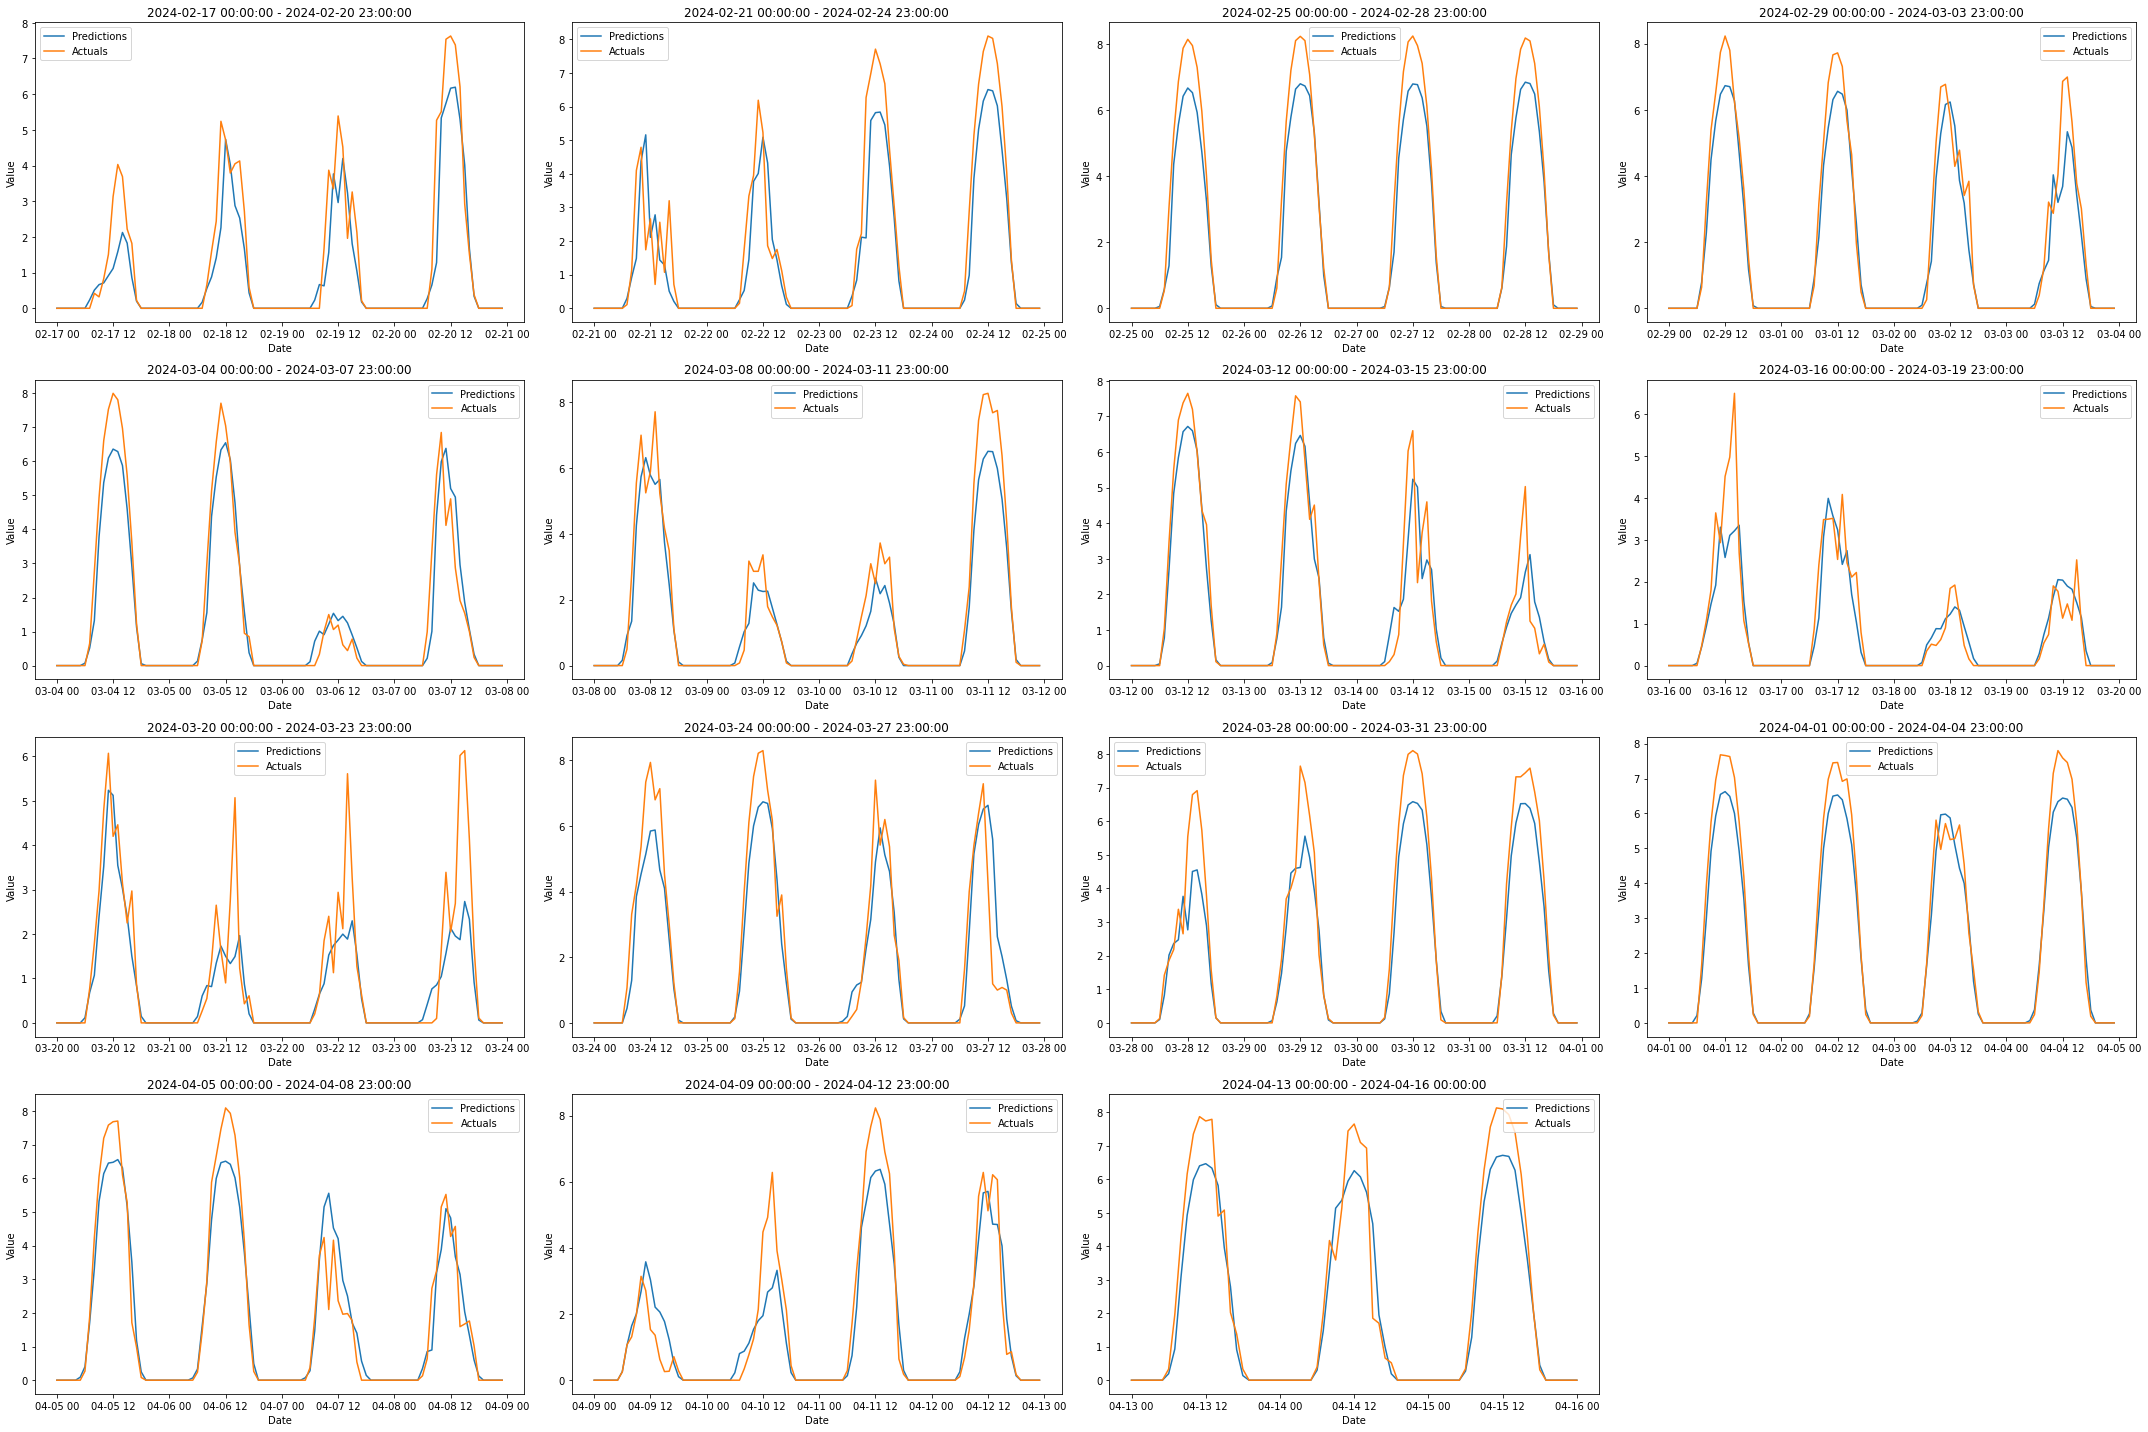

In [297]:
datetime_index = pd.DataFrame(last_2_months_df.index[24:])
test_results_with_datetime = pd.concat([datetime_index, test_results], axis=1).set_index('date')

days_per_subplot = 4

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(30, 20))
axes = axes.flatten()

for i, ax in enumerate(axes):
    start_idx = i * days_per_subplot * 24
    end_idx = min((i + 1) * days_per_subplot * 24, len(test_results_with_datetime))
    if start_idx < len(test_results_with_datetime):
        ax.plot(test_results_with_datetime.index[start_idx:end_idx], test_results_with_datetime['Val Predictions'].iloc[start_idx:end_idx], label='Predictions')
        ax.plot(test_results_with_datetime.index[start_idx:end_idx], test_results_with_datetime['Actuals'].iloc[start_idx:end_idx], label='Actuals')
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
        ax.set_title(f'{test_results_with_datetime.index[start_idx:end_idx].min()} - {test_results_with_datetime.index[start_idx:end_idx].max()}')
        ax.legend()
    else:
        # If the start index is out of range, remove the axis
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

These are the best and lastest models scores;

In [310]:
from sklearn.metrics import mean_squared_error
y_pred = loaded_model.predict(X_last)
mse = mean_squared_error(y_last, y_pred)
print("Mean Squared Error:", mse)
rmse = np.sqrt(mean_squared_error(y_last, y_pred))
print("Root Mean Squared Error:", rmse)
from sklearn.metrics import r2_score
r2 = r2_score(y_last, y_pred)
print("R2 Score:", r2)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_last, y_pred)
print("Mean Absolute Error:", mae)
# SMAPE could be misleading, there are a lot of 0 values in the dataset.
smape = symmetric_mean_absolute_percentage_error(y_last, y_pred)
print("Symmetric Mean Absolute Percentage Error:", smape)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Mean Squared Error: 0.5672647509556019
Root Mean Squared Error: 0.7531698022063829
R2 Score: 0.9115022433169341
Mean Absolute Error: 0.4173385843030987
Symmetric Mean Absolute Percentage Error: 1.7417823959371228


# Hiperparametre

In [20]:
import keras_tuner

def get_hyper_param(n_iteration):
  hyper_param = []  # learning_rate, n_hidden, timestep, epochs
  for i in range(n_iteration):
    current_params = []
    current_params.append(np.random.uniform(0.001,0.1))
    current_params.append(np.random.randint(16,101))
    current_params.append(np.random.randint(16,101))
    current_params.append(np.random.uniform(0.05, 0.25))
    hyper_param.append(current_params)
  return hyper_param

def build_model(hp):
  active_func = hp.Choice('activation', ["tanh"])
  neur1 =  hp.Int('neur1', min_value=32, max_value=64,step=16)
  neur2 =  hp.Int('neur2', min_value=64, max_value=128,step=32)
  neur3 =  hp.Int('neur3', min_value=128, max_value=256,step=64)
  dropout_ss = hp.Choice('dropout', [0.15, 0.2])
  learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')

  model = Sequential()
  model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(neur1, activation=active_func, return_sequences=True))
  model.add(Dropout(dropout_ss))
  model.add(LSTM(neur2, activation=active_func, return_sequences=True))
  model.add(Dropout(dropout_ss))
  model.add(LSTM(neur3, activation=active_func))
  model.add(Dropout(dropout_ss))
  model.add(Dense(units=1, activation=active_func))
  
  opt = Adam(learning_rate=learning_rate)
  model.compile(loss=MeanSquaredError(), optimizer=opt, metrics=[RootMeanSquaredError()])
  return model


In [21]:
tuner = keras_tuner.RandomSearch(build_model, objective='val_loss', max_trials=25)

In [22]:
tuner.search(X_train, y_train, epochs=25, validation_data=(X_val, y_val))
best_model = tuner.get_best_models()[0]

Trial 25 Complete [00h 12m 27s]
val_loss: 4.374276161193848

Best val_loss So Far: 3.8096542358398438
Total elapsed time: 06h 08m 33s


In [131]:
best_model.evaluate(X_test, y_test)

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.4096 - root_mean_squared_error: 2.3195


[4.585024356842041, 2.141698122024536]

In [23]:
checkpoint = [ModelCheckpoint('model.keras', save_best_only=True, verbose=1),
              EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, mode='min', verbose=1)]
min_val_loss = 999
histories = []
for i in range(5):
    losses = []
    hyper_parameter = get_hyper_param(128)
    for learning_rate, n_neurons_1, n_neurons_2, n_dropouts in hyper_parameter:
        history = fit_lstm(learning_rate, n_neurons_1, n_neurons_2, n_dropouts, checkpoint)
        losses.append(history.history['loss'])
        losses.append(history.history['val_loss'])
        histories.append([best_params, losses])
        current_val_loss = history.history['val_loss'][-1]
        if current_val_loss < min_val_loss:
            min_val_loss = current_val_loss
            best_params = [learning_rate, n_neurons_1, n_neurons_2, n_dropouts]
            best_history = history
            print('best_params',best_params)
    import matplotlib.pyplot as plt
    print(best_params, losses)
    plt.plot(best_history.history['loss'], label='Train Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


lr 0.08947271041812 n_neurons 22 83 n_dropouts 0.15120370365089947
Epoch 1/35
1533/1539 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6213 - root_mean_squared_error: 2.3676
Epoch 1: val_loss improved from inf to 4.53990, saving model to model.keras
1539/1539 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 5.6203 - root_mean_squared_error: 2.3674 - val_loss: 4.5399 - val_root_mean_squared_error: 2.1318
Epoch 2/35
1529/1539 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3722 - root_mean_squared_error: 2.3177
Epoch 2: val_loss improved from 4.53990 to 4.31339, saving model to model.keras
1539/1539 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 5.3720 - root_mean_squared_error: 2.3177 - val_loss: 4.3134 - val_root_mean_squared_error: 2.0786
Epoch 3/35
1534/1539 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.3574 - root_mean_squared_error: 2.3146
Epoch 3: val_loss improved from 4.31339 to 4.27283, saving model to model.keras
1539/1539 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 5.3574 - root_mean_squared_error: 2.31

KeyboardInterrupt: 